# DO NOT RUN THE CELLS IN THIS SECTION


*   **The code cells below are meant for random data generation to perform the analysis.**
*   **If you have data available ignore the cells in this section and jump right away to the next section.**




In [ ]:
# DO NOT RUN THIS CELL!!

import pandas as pd
import numpy as np
import random
from datetime import datetime, timedelta

# Set a random seed for reproducibility
random.seed(42)
np.random.seed(42)

# Parameters
num_entries = 1000
min_amount = 50000
max_amount = 1000000
earliest_date = datetime(2023, 9, 23)
loan_tenures = [3, 6, 12]  # Months for the loan tenure
num_customers = 300  # Number of unique customers (random)

# Generate purely numeric Customer IDs (CUS_ID)
cus_ids = np.random.choice(range(1, num_customers + 1), num_entries)

# Generate random dates between the earliest date and today
dates = [earliest_date + timedelta(days=random.randint(0, (datetime.today() - earliest_date).days)) for _ in range(num_entries)]

# Generate random amounts between min and max amount
amounts = np.random.randint(min_amount, max_amount + 1, size=num_entries)

# Randomly assign loan tenures (3, 6, or 12 months)
tenures = np.random.choice(loan_tenures, size=num_entries)

# Create the DataFrame
data = {
    'CUS_ID': cus_ids,
    'DATE': dates,
    'AMOUNT': amounts,
    'TENURE': tenures
}

df = pd.DataFrame(data)

# Display the first few rows of the generated dataset
print(df.head())

# Save to a CSV file
df.to_csv("loan_data.csv", index=False)


   CUS_ID       DATE  AMOUNT  TENURE
0     103 2024-08-15  995456       6
1     271 2023-11-19  791804       6
2     107 2023-10-05  223532       6
3      72 2024-02-10  664685       3
4     189 2024-01-26  647135      12


In [ ]:
# DO NOT RUN THIS CELL!!
from google.colab import files
files.download('loan_data.csv')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Data import and exploration


In [ ]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from google.colab import files

uploaded = files.upload()

Saving loan_data.csv to loan_data.csv


In [ ]:
df = pd.read_csv('loan_data.csv')
df.head()

,CUS_ID,DATE,AMOUNT,TENURE
0,103,2024-08-15,995456,6
1,271,2023-11-19,791804,6
2,107,2023-10-05,223532,6
3,72,2024-02-10,664685,3
4,189,2024-01-26,647135,12


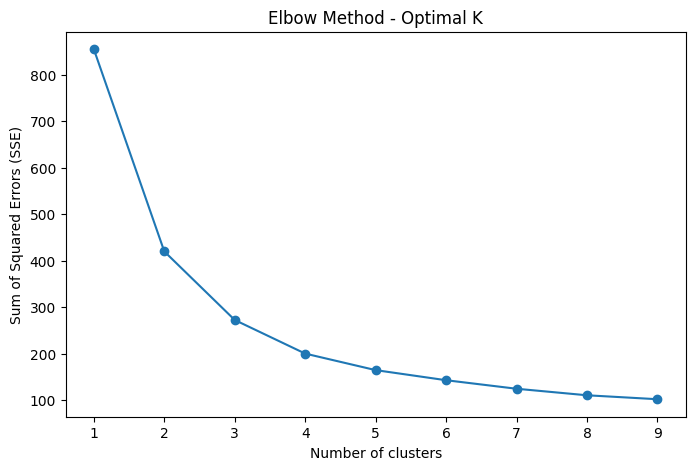

In [ ]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

# Step 1: Feature Engineering for RFM Analysis

# Calculate Recency, Frequency, and Monetary features
# Convert 'DATE' to datetime
df['DATE'] = pd.to_datetime(df['DATE'])

# Recency: Days since last loan for each customer
now = datetime.today()
recency_df = df.groupby('CUS_ID').agg({'DATE': lambda x: (now - x.max()).days}).reset_index()
recency_df.columns = ['CUS_ID', 'Recency']

# Frequency: Count of loans per customer
frequency_df = df.groupby('CUS_ID').agg({'DATE': 'count'}).reset_index()
frequency_df.columns = ['CUS_ID', 'Frequency']

# Monetary: Total loan amount per customer
monetary_df = df.groupby('CUS_ID').agg({'AMOUNT': 'sum'}).reset_index()
monetary_df.columns = ['CUS_ID', 'Monetary']

# Merge the RFM data into a single DataFrame
rfm_df = recency_df.merge(frequency_df, on='CUS_ID').merge(monetary_df, on='CUS_ID')

# Step 2: Standardize the RFM features
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm_df[['Recency', 'Frequency', 'Monetary']])

# Step 3: K-Means Clustering
# Determine the optimal number of clusters using the Elbow Method
sse = []
k_range = range(1, 10)
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(rfm_scaled)
    sse.append(kmeans.inertia_)

# Plot the Elbow graph
plt.figure(figsize=(8, 5))
plt.plot(k_range, sse, marker='o')
plt.title('Elbow Method - Optimal K')
plt.xlabel('Number of clusters')
plt.ylabel('Sum of Squared Errors (SSE)')
plt.show()


   Cluster  Recency  Frequency   Monetary  CUS_ID
0        0    192.5        2.0   980431.0      68
1        1     40.0        5.0  3028609.0     103
2        2     55.0        3.0  1291627.5     114


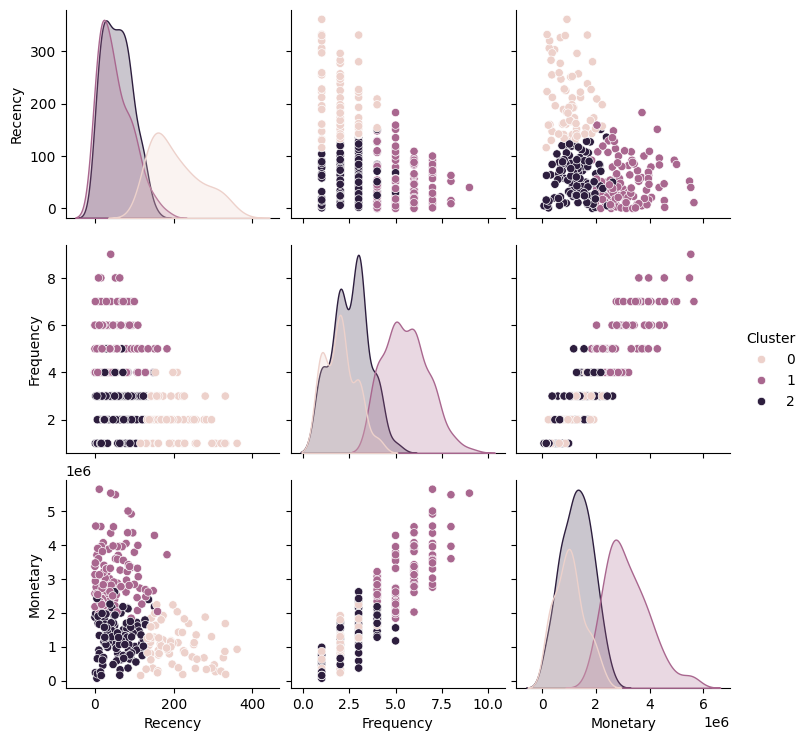

In [ ]:
# Choose the optimal number of clusters (e.g., 3 or 4 based on the elbow plot)
optimal_k = 3
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
rfm_df['Cluster'] = kmeans.fit_predict(rfm_scaled)

# Step 4: Analyze the cluster segments
# Group by clusters and get the mean of each RFM feature per cluster
cluster_analysis = rfm_df.groupby('Cluster').agg({
    'Recency': 'median',
    'Frequency': 'median',
    'Monetary': 'median',
    'CUS_ID': 'count'  # Count of customers in each cluster
}).reset_index()

# Display the cluster characteristics
print(cluster_analysis)

# Visualizing the clusters using seaborn
sns.pairplot(rfm_df, hue='Cluster', vars=['Recency', 'Frequency', 'Monetary'])
plt.show()


In [ ]:
cluster_analysis

,Cluster,Recency,Frequency,Monetary,CUS_ID
0,0,192.5,2.0,980431.0,68
1,1,40.0,5.0,3028609.0,103
2,2,55.0,3.0,1291627.5,114


# Cluster Analysis & explanation and RFM Analysis


In [ ]:
print("Cluster Analysis:")
overall_recency_median = cluster_analysis['Recency'].median()
overall_frequency_median = cluster_analysis['Frequency'].median()
overall_monetary_median = cluster_analysis['Monetary'].median()

for index, row in cluster_analysis.iterrows():
    cluster_num = row['Cluster']
    recency = row['Recency']
    frequency = row['Frequency']
    monetary = row['Monetary']
    customer_count = row['CUS_ID']

    print(f"\nCluster {cluster_num}:")
    print(f"- Number of Customers: {customer_count}")
    print(f"- Median Recency: {recency:.2f} days")
    print(f"- Median Frequency: {frequency:.2f} loans")
    print(f"- Median Monetary Value: KES {monetary:.2f}")

    # Interpret Recency
    if recency < overall_recency_median:
        print("- This cluster has customers who have taken out a loan recently.")
    else:
        print("- This cluster has customers who have not taken out a loan recently.")

    # Interpret Frequency
    if frequency > overall_frequency_median:
        print("- This cluster has customers who frequently take out loans.")
    else:
        print("- This cluster has customers who don't frequently take out loans.")

    # Interpret Monetary Value
    if monetary > overall_monetary_median:
        print("- This cluster has customers who tend to take out larger loans or have high loan values.")
    else:
        print("- This cluster has customers who tend to take out smaller loans or have low loan values.")

# Example of potential names for clusters based on patterns
# Cluster 0: Might represent "Loyal Customers" with high frequency and monetary value.
# Cluster 1: Might represent "At-Risk Customers" with high recency (haven't borrowed recently).
# Cluster 2: Might represent "New Customers" with low frequency and monetary value.
# Cluster 3: Might represent "Premium Customers" with low recency, high frequency, and high monetary value.


Cluster Analysis:

Cluster 0.0:
- Number of Customers: 68.0
- Median Recency: 192.50 days
- Median Frequency: 2.00 loans
- Median Monetary Value: KES 980431.00
- This cluster has customers who have not taken out a loan recently.
- This cluster has customers who don't frequently take out loans.
- This cluster has customers who tend to take out smaller loans or have low loan values.

Cluster 1.0:
- Number of Customers: 103.0
- Median Recency: 40.00 days
- Median Frequency: 5.00 loans
- Median Monetary Value: KES 3028609.00
- This cluster has customers who have taken out a loan recently.
- This cluster has customers who frequently take out loans.
- This cluster has customers who tend to take out larger loans or have high loan values.

Cluster 2.0:
- Number of Customers: 114.0
- Median Recency: 55.00 days
- Median Frequency: 3.00 loans
- Median Monetary Value: KES 1291627.50
- This cluster has customers who have not taken out a loan recently.
- This cluster has customers who don't frequent

In [ ]:
# Define segments based on cluster characteristics using median
segments = {}

for index, row in cluster_analysis.iterrows():
    cluster_num = row['Cluster']
    recency = row['Recency']
    frequency = row['Frequency']
    monetary = row['Monetary']

    # High Value Loyal Customers: High frequency, high monetary, low recency (recent loans)
    if frequency > rfm_df['Frequency'].median() and monetary > rfm_df['Monetary'].median() and recency < rfm_df['Recency'].median():
        segments[cluster_num] = "High Value Loyal Customers"

    # At-Risk Customers: Low frequency, low monetary, high recency (haven’t borrowed in a while)
    elif frequency < rfm_df['Frequency'].median() and monetary < rfm_df['Monetary'].median() and recency > rfm_df['Recency'].median():
        segments[cluster_num] = "At-Risk Customers"

    # Frequent Low-Value Borrowers: High frequency but low monetary value
    elif frequency > rfm_df['Frequency'].median() and monetary < rfm_df['Monetary'].median():
        segments[cluster_num] = "Frequent Low-Value Borrowers"

    # New Customers: High recency (recent loans), low frequency
    elif recency > rfm_df['Recency'].median() and frequency < rfm_df['Frequency'].median():
        segments[cluster_num] = "New Customers"

    # Catch-all category for customers not fitting above
    else:
        segments[cluster_num] = "Other"

# Add segment labels to the rfm_df
rfm_df['Segment'] = rfm_df['Cluster'].map(segments)

# Display the customer segmentation results
print(rfm_df.groupby('Segment').agg({'CUS_ID': 'count'}))

# You can further analyze each segment by examining the characteristics of the customers within that segment
# and designing targeted marketing or retention strategies.

# For example:
# - For "High Value Loyal Customers", offer exclusive promotions or rewards.
# - For "At-Risk Customers", send targeted re-engagement campaigns.
# - For "Frequent Low-Value Borrowers", offer products or services to increase their loan values.
# - For "New Customers", offer welcome bonuses or promotions to encourage repeat business.


                            CUS_ID
Segment                           
At-Risk Customers               68
High Value Loyal Customers     103
Other                          114


In [ ]:
rfm_df

,CUS_ID,Recency,Frequency,Monetary,Cluster,Segment
0,1,52,8,5490651,1,High Value Loyal Customers
1,2,24,3,2343137,2,Other
2,3,326,1,676759,0,At-Risk Customers
3,4,33,4,2072915,2,Other
4,5,59,7,3699929,1,High Value Loyal Customers
...,...,...,...,...,...,...
280,296,7,4,2543838,1,High Value Loyal Customers
281,297,16,1,151520,2,Other
282,298,259,1,633417,0,At-Risk Customers
283,299,168,2,1795288,0,At-Risk Customers
